# COVIDcast Data Smoothing
In this document, we compare different methods of smoothing COVIDcast signals. See the associated README.md file for the mathematical description of the methods.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import covidcast
from datetime import date

from delphi_utils import Smoother

## An Example: California Google Health Trends
To begin, let's load a raw example signal, say the [Google Health Trends signal](https://github.com/cmu-delphi/delphi-epidata/blob/main/docs/api/covidcast-signals/ght.md) `ght` which records Google search activity.

In [2]:
filename = "ght_raw.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="state", geo_values="ca")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

Let's take a look at this signal and a few approaches to smoothing it: local linear regression, moving average, and the Savtizky-Golay (SG) filter.

We can make a few observations from the plot below:
* there's an overall similarity between the results of the local linear regression and the SG filter; the SG filter tends to be a little more sensitive to noise and is therefore more jittery, but for this reason better matches the height, location, and width of the peaks.
* setting the SG filter's window length to 2 weeks introduces too much noise; setting it to 3 or 4 weeks seems to attenuate the noise, but introduces a few large deviations, namely around data point 75; a window of 5 introduces large deviations; these deviations seem to be mainly caused by the large spike in the data
* setting the SG filter to polynomial degree 2 also has a taming effect on the noise; setting the polynomial degree higher reduces the deviations from the large spike, but introduces more sensitivity to noise
* the moving average lags behind the true peaks in the data

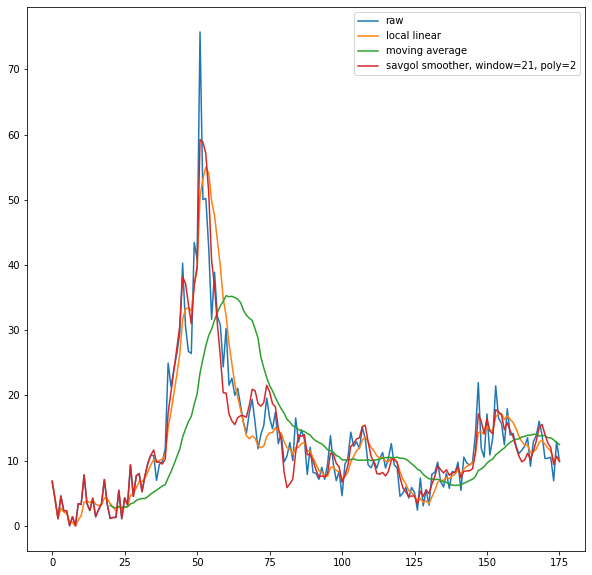

In [3]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='local_linear', gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="local linear")
smoother = Smoother(method_name='moving_average')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="moving average")
smoother = Smoother(window_length=35, poly_fit_degree=4)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol smoother, window=21, poly=2")
plt.legend()

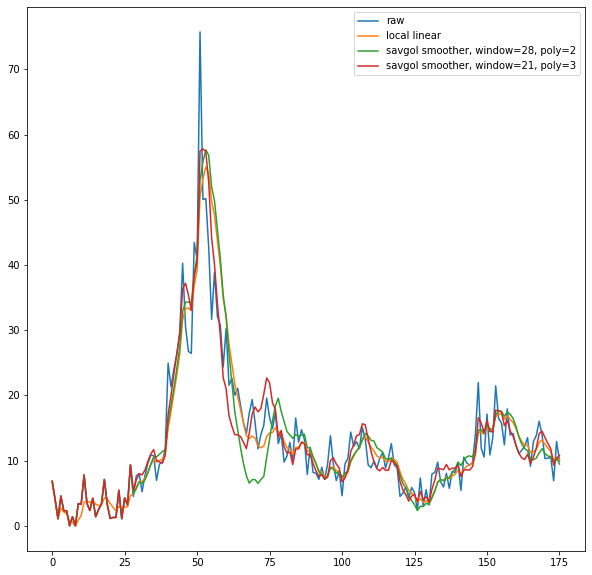

In [4]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='local_linear', gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="local linear")
smoother = Smoother(window_length=28, poly_fit_degree=2)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol smoother, window=28, poly=2")
smoother = Smoother(window_length=28, poly_fit_degree=3)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol smoother, window=21, poly=3")
plt.legend()

What if we used a Gaussian weighted regression within the SG filter? Seems to be doing reasonable things. Test more later.

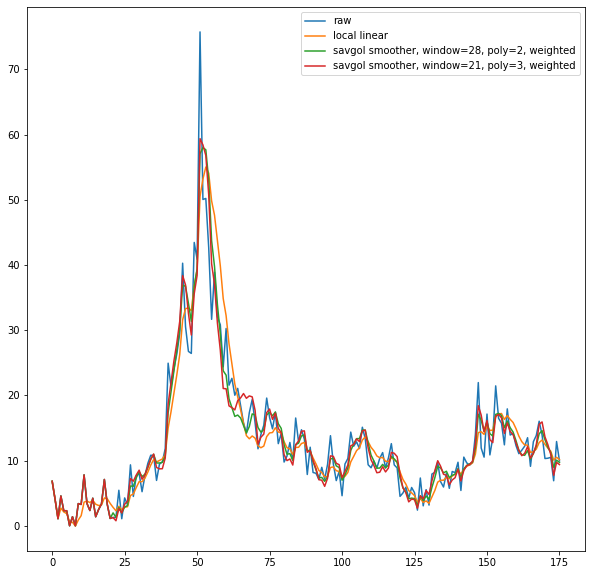

In [18]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='local_linear', gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="local linear")
smoother = Smoother(window_length=21, poly_fit_degree=2, savgol_weighted=True, gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol smoother, window=28, poly=2, weighted")
smoother = Smoother(window_length=21, poly_fit_degree=3, savgol_weighted=True, gaussian_bandwidth=1000)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol smoother, window=21, poly=3, weighted")
plt.legend()

Press et. al. suggest a heuristic for SG parameter setting: for a degree 4 polynomial, use a window length that is 1 to 2 times the FWHM (full width at half maximum) of the bumps

Here we see the coefficients for a past window of length 14 (including the present) and polynomial degree 3. It is clear that most of the weight is on the most recent week of data, while the previous week's data acts as a counterweight.

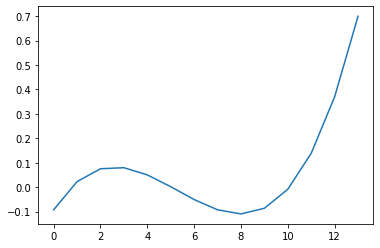

In [4]:
plt.plot(smoother.coeffs)

## Zero-censored Data
Suppose we randomly censor some small data points by setting them to zero. How well do the smoothers perform?

Here we see that the SG method can dip into the negatives, which is not great, but can be fixed by zero-thresholding. SG is also more sensitive to noise, so a larger window (4 weeks) helps. Reducing the degree down to 2 makes the method less noise-sensitive. However, the height of the peak isn't as well captured. 

Perhaps instead of zero-censoring, we can instead keep the last non-threshold value to reduce the size of the dips?

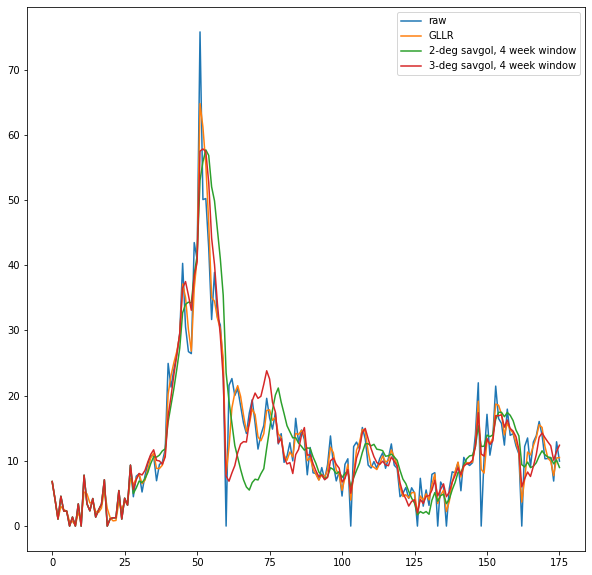

In [61]:
def censor_data(x, n):
    """
    Randomly zero out n values from the array.
    """
    for i in range(n):
        ix = np.random.randint(len(x))
        x[ix] = 0
    return x

data_censored = censor_data(np.array(data_raw.value), 10)
plt.figure(figsize=(10,10))
plt.plot(data_censored, label="raw")
smoother = Smoother('local_linear')
plt.plot(smoother.smooth(data_censored), label="GLLR")
smoother = Smoother('savgol', window_length=28, poly_fit_degree=2)
plt.plot(smoother.smooth(data_censored), label="2-deg savgol, 4 week window")
smoother = Smoother('savgol', window_length=28, poly_fit_degree=3)
plt.plot(smoother.smooth(data_censored), label="3-deg savgol, 4 week window")
plt.legend()

## Other Signals
The other signals had obstacles to a clear comparison.

The `doctor-visits` [signal](https://github.com/cmu-delphi/delphi-epidata/blob/main/docs/api/covidcast-signals/doctor-visits.md) seems to be an indicator already smoothed by the provider. The raw data does not appear to be available.

The `fb-survey` signal requires access to the survey data. 
> Individual survey responses are held by CMU and are sharable with other health researchers under a data use agreement.

The `google-survey` signal uses a similar smoothing procedure to `fb-survey`, which requries access to the underlying survey data. The results of applying smoothing to the already-estimated data is not great.

The `hospital-admissions` signal, like `doctor-surveys` comes already smoothed.

In [354]:
data_raw = covidcast.signal(data_source="doctor-visits", 
                            signal="raw_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")
data_smooth = covidcast.signal(data_source="doctor-visits", 
                            signal="smoothed_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")

In [ ]:
data_raw = covidcast.signal(data_source="fb-survey", 
                            signal="raw_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")
data_smooth = covidcast.signal(data_source="fb-survey", 
                            signal="smoothed_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")

In [363]:
data_raw = covidcast.signal(data_source="google-survey", 
                            signal="raw_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")
data_smooth = covidcast.signal(data_source="google-survey", 
                            signal="smoothed_cli", 
                            start_day=None, 
                            end_day=None,
                            geo_type="state", 
                            geo_values="ca")

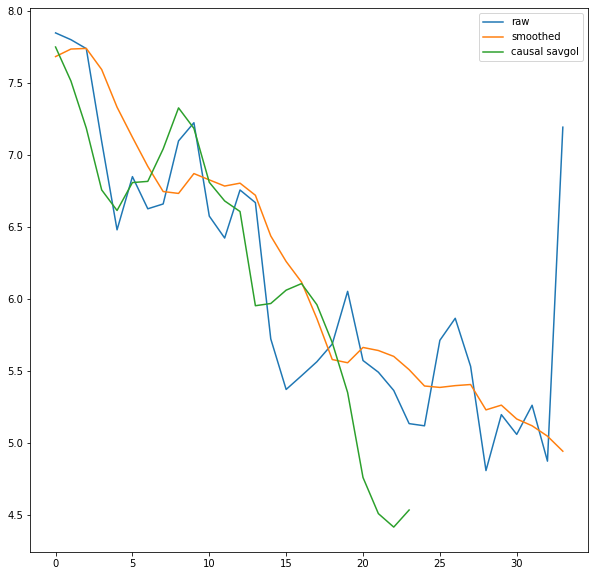

In [389]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
plt.plot(np.array(data_smooth.value), label="smoothed")
plt.plot(causal_savgol_filter(np.array(data_raw.value), 21, 4), label="causal savgol")
plt.legend()

In [ ]:
data_raw = covidcast.signal(data_source="hospital-admissions", 
                            signal="raw_cli", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")
data_smooth = covidcast.signal(data_source="hospital-admissions", 
                            signal="smoothed_cli", 
                            start_day=None, 
                            end_day=None,
                            geo_type="state", 
                            geo_values="ca")

In [392]:
data_raw = covidcast.signal(data_source="jhu-csse", 
                            signal="confirmed_incidence_num", 
                            start_day=None, 
                            end_day=None, 
                            geo_type="state", 
                            geo_values="ca")
data_smooth = covidcast.signal(data_source="jhu-csse", 
                            signal="deaths_incidence_num", 
                            start_day=None, 
                            end_day=None,
                            geo_type="state", 
                            geo_values="ca")

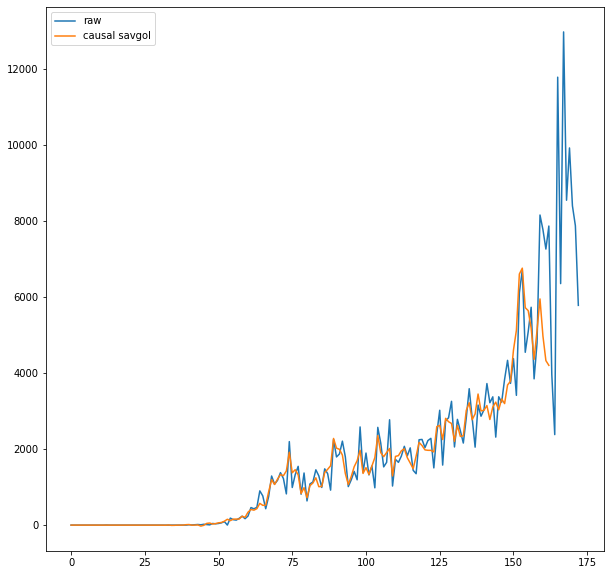

In [397]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
plt.plot(causal_savgol_filter(np.array(data_raw.value), 21, 4), label="causal savgol")
plt.legend()